In [1]:
# Standard library imports
from datetime import datetime
import time
import math
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import MetaTrader5 as mt
import pmdarima as pm
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA



C:\Users\ahmad\AppData\Local\Temp\ipykernel_7640\1098074014.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
mt.initialize()

True

In [3]:
#This is a demo account I have created to sign into when on Metatrader5
login = 10001610777
password = 'Td@oQj5f'
server = 'MetaQuotes-Demo'
mt.login(login, password, server)

True

In [4]:
#MT5 DATASET
symbol = 'XAUUSD'
timeframe = mt.TIMEFRAME_D1
date_from = datetime(2023, 2, 15)
date_to = datetime(2024, 2, 5)

mt_data = pd.DataFrame(mt.copy_rates_range(symbol, timeframe, date_from, date_to))
mt_data['time'] = pd.to_datetime(mt_data['time'], unit='s')
mt_data.set_index('time', inplace=True)


mt_data


,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2023-02-15,1853.50,1860.11,1830.45,1836.08,130104,3,0
2023-02-16,1836.47,1845.30,1827.64,1836.25,136199,4,0
2023-02-17,1835.29,1843.60,1818.90,1841.86,130134,3,0
2023-02-20,1841.20,1847.48,1837.29,1841.26,68257,5,0
2023-02-21,1842.18,1843.84,1830.23,1834.90,127575,4,0
...,...,...,...,...,...,...,...
2024-01-29,2023.75,2037.46,2019.18,2031.72,288179,15,0
2024-01-30,2032.77,2048.64,2028.96,2036.39,414128,16,0
2024-01-31,2036.44,2056.07,2030.79,2038.75,569048,7,0


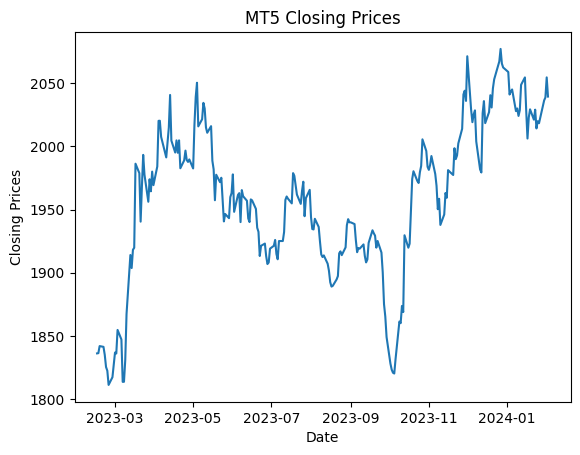

In [5]:
# Plot MT5 data
plt.plot(mt_data.index, mt_data['close'])
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('MT5 Closing Prices')
plt.show()

In [6]:
#Train Test Split

to_row = int(len(mt_data) * 0.9)
training_data = list(mt_data[0:to_row]['close'])
testing_data = list(mt_data[to_row:]['close'])
testing_data


[2062.47,
 2058.89,
 2041.04,
 2043.5,
 2045.06,
 2027.92,
 2030.02,
 2024.09,
 2028.63,
 2048.76,
 2054.6,
 2028.21,
 2006.2,
 2022.84,
 2029.33,
 2021.15,
 2029.05,
 2014.21,
 2019.92,
 2018.34,
 2031.72,
 2036.39,
 2038.75,
 2054.62,
 2039.44]

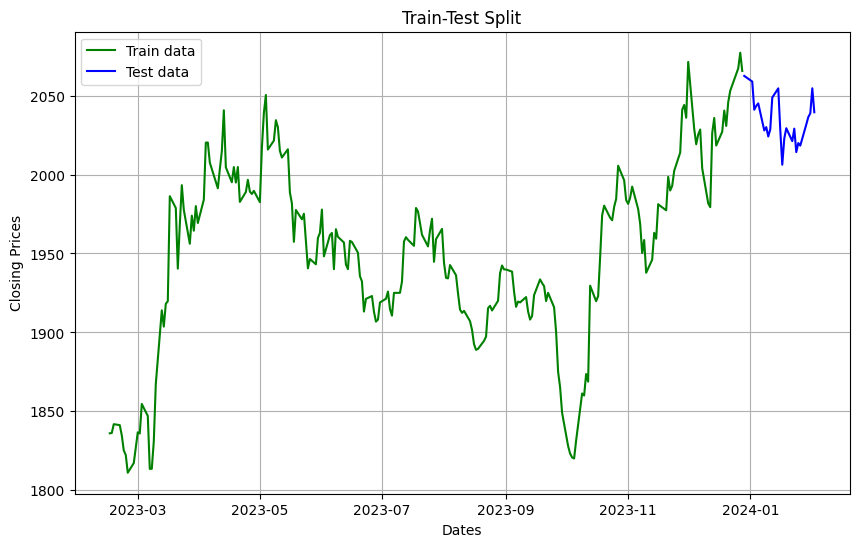

In [7]:
# Split data into test and training set
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(mt_data.index[:to_row], training_data, color='green', label='Train data')
plt.plot(mt_data.index[to_row:], testing_data, color='blue', label='Test data')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.title('Train-Test Split')
plt.legend()
plt.show()


In [8]:
warnings.simplefilter('ignore', category=ConvergenceWarning)


In [9]:
model_predictions = []
n_test_obser = len(testing_data)


In [10]:
autoarima_model = pm.auto_arima(training_data, seasonal=False, suppress_warnings=True)



In [11]:
best_pdq = autoarima_model.order

In [12]:
for i in range(n_test_obser):
    model = sm.tsa.ARIMA(training_data, order=best_pdq)
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    model_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)


In [13]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  249
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1027.835
Date:                Tue, 02 Apr 2024   AIC                           2065.670
Time:                        11:58:42   BIC                           2083.237
Sample:                             0   HQIC                          2072.741
                                - 249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3415      0.119      2.862      0.004       0.108       0.575
ar.L2         -0.8413      0.125     -6.747      0.000      -1.086      -0.597
ma.L1         -0.3706      0.146     -2.542      0.0

In [14]:
print("Final Prediction:", model_predictions[-1])

Final Prediction: 2054.2776764349433


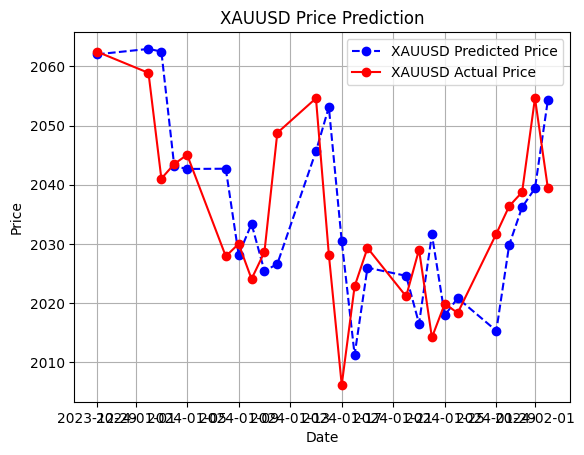

In [15]:

plt.grid(True)
date_range = mt_data.index[to_row:to_row + len(testing_data)]

# Plot the predicted and actual prices
plt.plot(date_range, model_predictions[:len(date_range)], color='blue', marker='o', linestyle='dashed', label='XAUUSD Predicted Price')
plt.plot(date_range, testing_data, color='red', marker='o', label='XAUUSD Actual Price')

plt.title('XAUUSD Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [16]:
#report performance
mape = np.mean(np.abs(np.array(model_predictions[:len(testing_data)]) - np.array(testing_data)) / np.abs(testing_data))
print('MAPE: ' + str(mape))




MAPE: 0.004848914636956181


In [17]:
# Prepare data for rendering in the template
    forex_symbol = symbol
    current_price = mt_data['close'].iloc[-1]  # Get the last closing price
    time_interval = '1 day'  # Update this based on your data
    prediction_models = ['ARIMA', 'AutoARIMA']  # Update this based on the models used

    # Create context for rendering the template
    context = {
        'forex_symbol': forex_symbol,
        'current_price': current_price,
        'time_interval': time_interval,
        'prediction_models': prediction_models,
        'model_predictions': model_predictions,
        'testing_data': testing_data,
        'mape': mape
    }

IndentationError: unexpected indent (1101371434.py, line 2)